In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

## Importing Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

100%|██████████| 1.76G/1.76G [03:24<00:00, 9.26MB/s]

Extracting files...


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\andrewmvd\lung-and-colon-cancer-histopathological-images\versions\1


## Visualizing the Data

In [5]:
classes = ['lung_aca', 'lung_n', 'lung_scc']

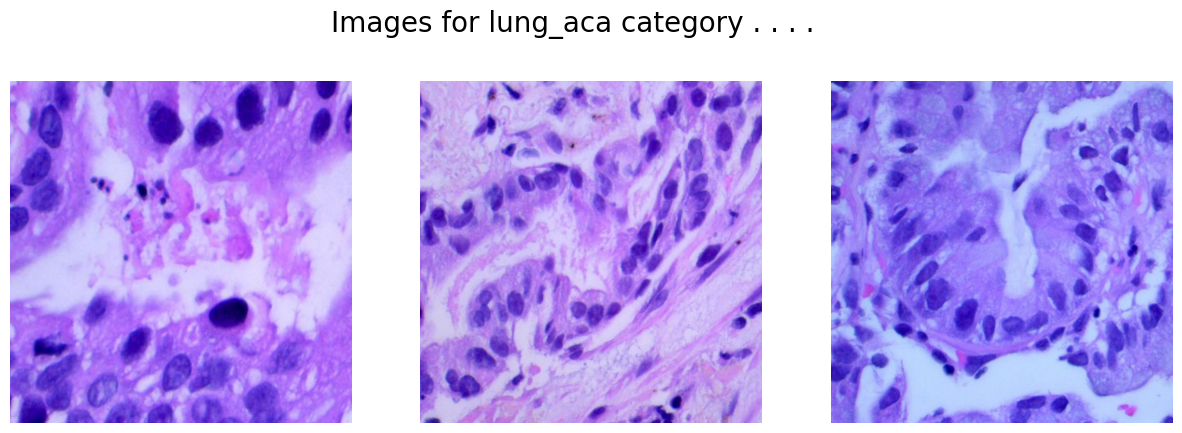

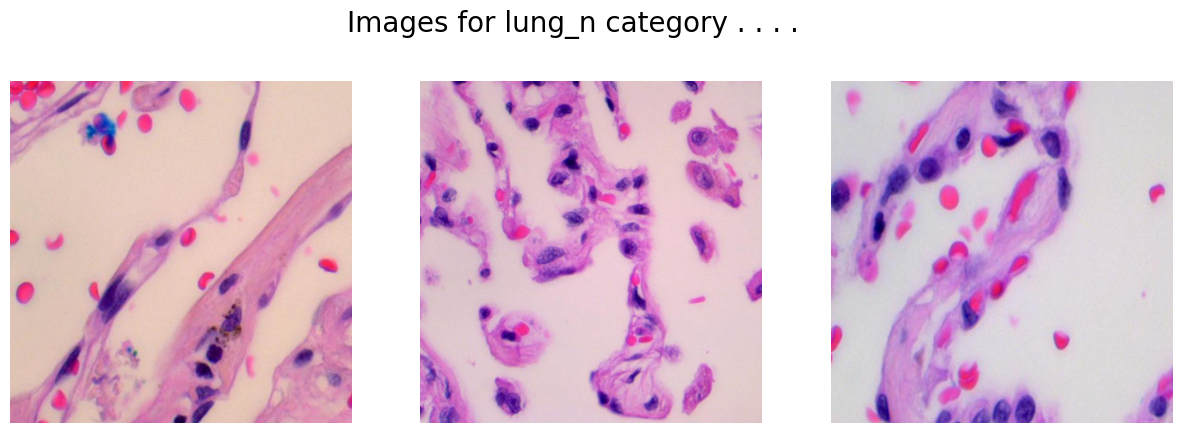

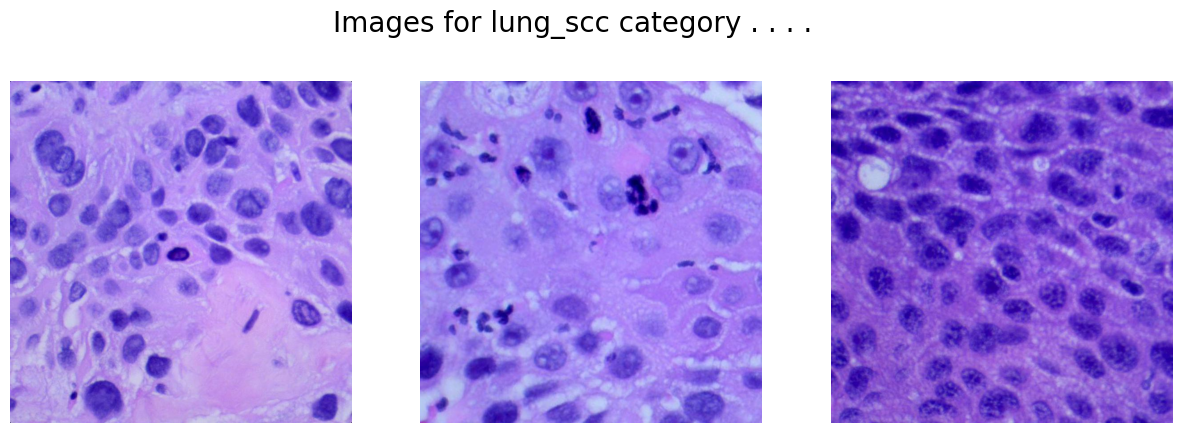

In [6]:
path = 'lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

This helps in identifying the nature of images that the model will be trained on. Classes will contain the names: 'lung_n', 'lung_aca' and 'lung_scc' corresponding to Normal, Lung Adenocarcinoma and Lung Squamous Cell Carcinoma.

## Preparing the Dataset

In [7]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)

1. Image Resizing: Since large images are computationally expensive to process we resize them to a standard size (256x256) using numpy array. We used 10 epochs with batch size of 64.
2. One hot encoding: Labels (Y) are converted to one-hot encoded vectors using pd.get_dummies(). This allows the model to output soft probabilities for each class.
3. Train-Test Split: We split the dataset into training and validation sets i.e., 80% for training and 20% for validation. This allows us to evaluate the model's performance on unseen data.

## Model Development

In [8]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

1. Sequential(): Builds a linear stack of layers.
2. Conv2D(): Applies convolution with specified filters, kernel size, ReLU activation and padding.
3. MaxPooling2D(): Downsamples feature maps by taking max values over pool size.
4. Flatten(): Converts 2D feature maps into 1D vector.
5. Dense(): Fully connected layer with given units and activation.
6. BatchNormalization(): Normalizes activations to speed up training.
7. Dropout(): Randomly drops neurons to reduce overfitting.
8. model.summary(): Displays model architecture details.

## Model Compilation

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

1.  We use the Adam optimizer which adjusts the learning rate during training to speed up convergence.
2. Categorical cross entropy loss is appropriate as loss function for multi-class classification problems as it measures the difference between the predicted and actual probability distributions.
3. EarlyStopping: Stops training if validation accuracy doesn’t improve for a set number of epochs (patience).
4. ReduceLROnPlateau: Reduces learning rate when validation loss plateaus, controlled by patience and factor.
5. Custom myCallback class: Stops training early when validation accuracy exceeds 90%.
6. self.model.stop_training = True: Signals to stop training inside the callback.

## Model Training

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8518 - loss: 0.3601 - val_accuracy: 0.3667 - val_loss: 9.4575 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.9099 - loss: 0.2202 - val_accuracy: 0.7943 - val_loss: 0.4423 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 785s 4s/step - accuracy: 0.9227 - loss: 0.1901 - val_accuracy: 0.5767 - val_loss: 1.4065 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 793s 4s/step - accuracy: 0.9405 - loss: 0.1502 - val_accuracy: 0.8133 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 832s 4s/step - accuracy: 0.9493 - loss: 0.1306 - val_accuracy: 0.7837 - val_loss: 0.7397 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9542 - loss: 0.1175
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 794s 4s/step - accuracy: 0.9528 - loss: 0.122

1. model.fit() trains the model on training data X_train and Y_train.
2. validation_data provides validation inputs X_val and Y_val for evaluation each epoch.
3. batch_size sets the number of samples per training batch.
4. epochs defines how many times the model iterates over the entire training set.
5. verbose=1 displays training progress.
6. callbacks includes early stopping, learning rate reduction and custom callback to control training based on validation metrics.

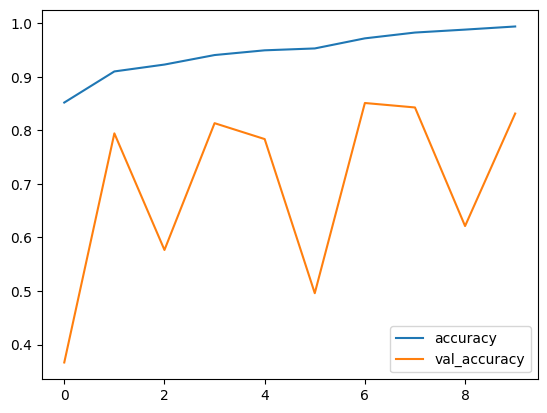

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

1. pd.DataFrame(history.history) converts training history into a DataFrame.
2. history_df.loc[:, ['accuracy', 'val_accuracy']].plot() plots training and validation accuracy.

## Model Evaluation

In [14]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step
              precision    recall  f1-score   support

    lung_aca       0.84      0.68      0.75       987
      lung_n       1.00      0.88      0.94       977
    lung_scc       0.76      0.99      0.86      1036

    accuracy                           0.85      3000
   macro avg       0.87      0.85      0.85      3000
weighted avg       0.86      0.85      0.85      3000



### metrics.classification_report() displays detailed evaluation metrics for each class based on true (Y_val) and predicted (Y_pred) labels, using class names from classes.

1. model.predict(X_val) generates predictions for validation data.
2. np.argmax(Y_val, axis=1) converts one-hot encoded true labels to class indices.
3. np.argmax(Y_pred, axis=1) converts predicted probabilities to class indices.
4. metrics.classification_report() prints precision, recall, f1-score and support for each class.